# TP 2 : Computer Vision

## Part 1 : segmentation

In this part of the TP, we are going to implement two approaches to image segmentation :

- algorithm of Otsu (histogram-based segmentation)
- a simple region-growing based algorithm

First, let us load some packages and define some helper functions (as in the previous TP)

(800, 586)

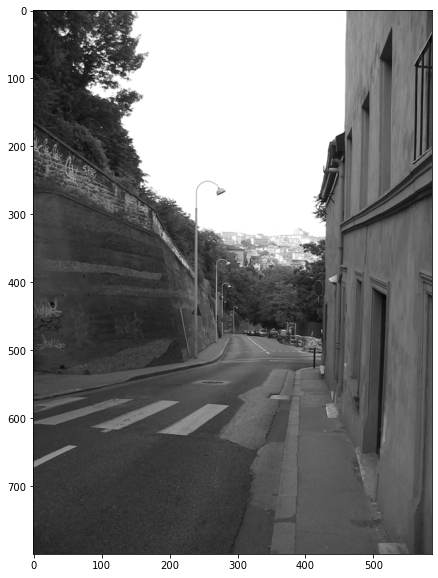

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

is_colab = False

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'crossing'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/crossing.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

## Otsu's algorithm

Otsu's method is based on finding a threshold to split the image into two separate segments, based simply on their grey-level values. Since the maximum number of grey-levels is finite (and small: 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the following criterion :

$argmin_{\tau} \: \omega_0(\tau)\sigma_0(\tau) + \omega_1(\tau)\sigma_1(t)$

where

- $\sigma_0(\tau)$ and $\sigma_1(\tau)$ are the variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are weights of the first and second regions

and 

- $\omega_0(\tau) = \sum_{p \in \Omega} \mathbb{1}_{\tau}(I(p)), \qquad$
- $\omega_1(\tau) = \sum_{p \in \Omega} 1-\mathbb{1}_{\tau}(I(p))$

and 

$\mathbb{1}_{\tau}(I(p)) =\begin{cases}
        1 \; \text{if} \: I(p)<=\tau\\
        0 \; \text{otherwise}
\end{cases}$

Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions. Furthemore, remember that the image is normalised between 0 and 1, with 256 discrete values. Choose the threshold values accordingly.

In [2]:
def segmentation_otsu(img):
    img_flatten = img.reshape(-1)
    criterion = (float("inf"), float("inf")) # tau, value
    
    for tau in np.linspace(0, 1, num=256):
        
        region_0, region_1 = [pixel for pixel in img_flatten if pixel < tau], [pixel for pixel in img_flatten if pixel >= tau]
        
        sigma_0, sigma_1 = np.var(region_0), np.var(region_1)
        omega_0, omega_1 = len(region_0), len(region_1)
        
        value = sigma_0 * omega_0 + sigma_1 * omega_1
        if value < criterion[1]:
            criterion = tau, value
            
            
    tau_out = criterion[0]
    img_out = img.copy()
    for i in range(img_out.shape[0]):
        for j in range(img_out.shape[1]):
            
            if img_out[i][j] >= tau_out:
                img_out[i][j] = 1
            else:
                img_out[i][j] = 0
            
    return img_out,tau_out

Carry out the segmentation on the input image and display the result

/Users/hugorialan/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/hugorialan/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/hugorialan/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


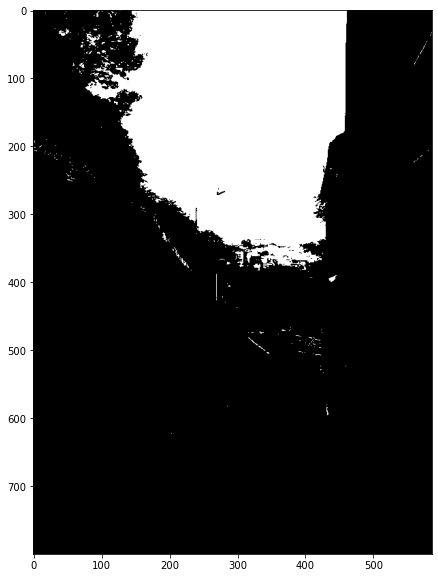

In [3]:
img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

In [4]:
tau

0.6392156862745098

__Question 1.1__ What problem can you see with the segmentation result ? What technique(s) (seen in the lesson) could you use to clean the result up ? 

__Answer__ On voit qu'une partie de la region 1 se retrouve dans la région 2, les régions ne sont pas complètement séparées. On voudrait plutôt avoir le ciel dans une région puis la terre dans une autre. 

Pour régler ce problème, dans ce cas on peut faire une érosion (pour supprimer les fines parties blanches) puis une dilation pour revenir à l'état initial. Cela va régler le problème seulement pour les fines parties blanches qui se sont retrouver dans le noir. 

Carry this out on the output image, and imwrite the result. You can find the necessary function(s) in the following package :

skimage.morphology

Choose the neighbourhood parameter of the functions to obtain the best results.

__Question 1.2__ In which order should you carry out the operations (you can test the different possibilities) ? Why ?

__Answer__ Les deux fonctionnent mais l'erosion avant la dilation améliore les résultats sur cette image. En effet l'erosion permet de supprimer les petites region 'outliers', la dilation permet de revnir à l'etat initial pour la region principale. 

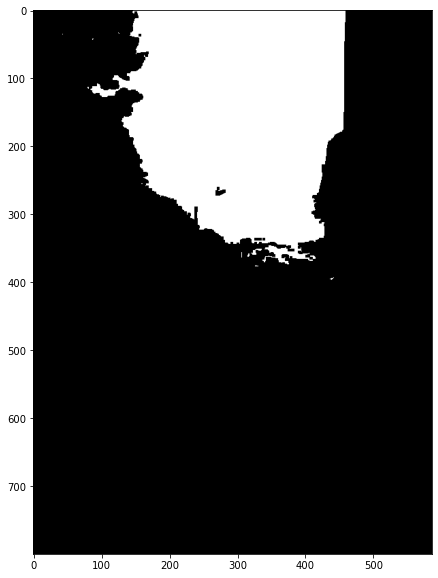

In [5]:
import skimage.morphology as morph
from skimage.morphology import square

neighbourhood_size = 4
img_out_otsu_cleaned =  morph.dilation(img_out_otsu, square(neighbourhood_size))
img_out_otsu_cleaned =  morph.erosion(img_out_otsu, square(neighbourhood_size))

display_image(img_out_otsu_cleaned)
write_image(img_out_otsu_cleaned,file_name+'_segmentation_otsu_cleaned_1.png')

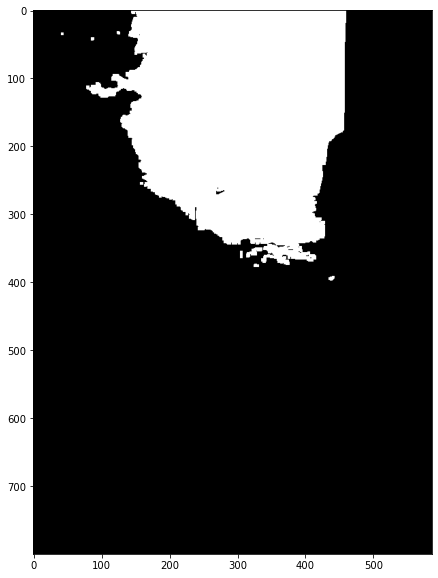

In [6]:
import skimage.morphology as morph
from skimage.morphology import square

neighbourhood_size = 4
img_out_otsu_cleaned =  morph.erosion(img_out_otsu, square(neighbourhood_size))
img_out_otsu_cleaned =  morph.dilation(img_out_otsu_cleaned, square(neighbourhood_size))

display_image(img_out_otsu_cleaned)
write_image(img_out_otsu_cleaned,file_name+'_segmentation_otsu_cleaned_1.png')

On voit que dilation puis erosion est meilleur pour la partie noir. Erosion puis dilation est par contre meilleur pour la partie blanche. L'ordre a son importance. soit on applique un 'opening', soit un 'closing'.

Let's change the image, and carry out the segmentation again.

/Users/hugorialan/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/hugorialan/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/hugorialan/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


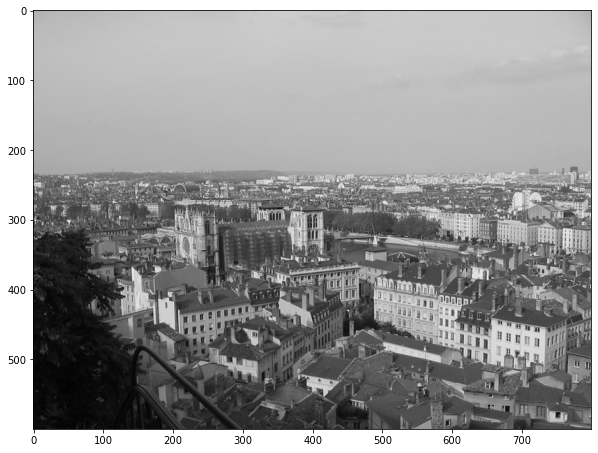

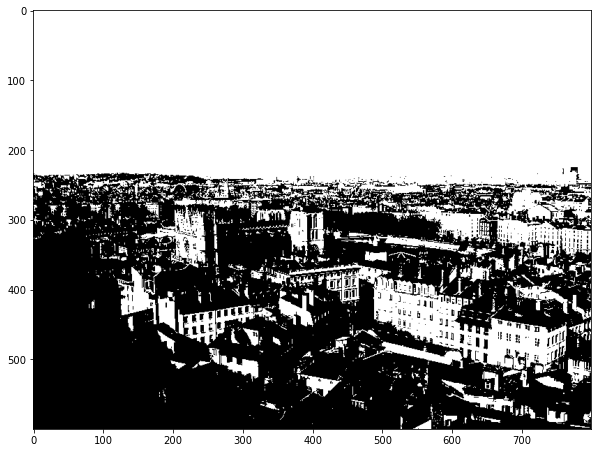

In [7]:
file_name = 'town'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/town.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

As we can see, there is no notion of connectivity in the algorithm of Otsu (two regions far away can be in the same segment). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add pixels progressively to the region, according to a criterion. We choose the following criterion :

- $I(p)$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [8]:
import scipy.ndimage.morphology as scipy_morphology

def initialize_segmentation(seed_pt,img_shape):
    tau = 5.0
    seg_init = np.ones(img_shape)
    seg_init[seed_pt] = 0
    seg_init = scipy_morphology.distance_transform_edt(seg_init)
    
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            
            if seg_init[i][j] >= tau:
                seg_init[i][j] = 0
            else:
                seg_init[i][j] = 1

    return seg_init

initialize_segmentation((5,5), (10,10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.]])

Now, create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

You will have to choose a neighbourhood that indicates which neighbouring pixels we want to try and include in the region. Use the following neighbourhood: $$ \begin{pmatrix} 0 & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 0\end{pmatrix}$$

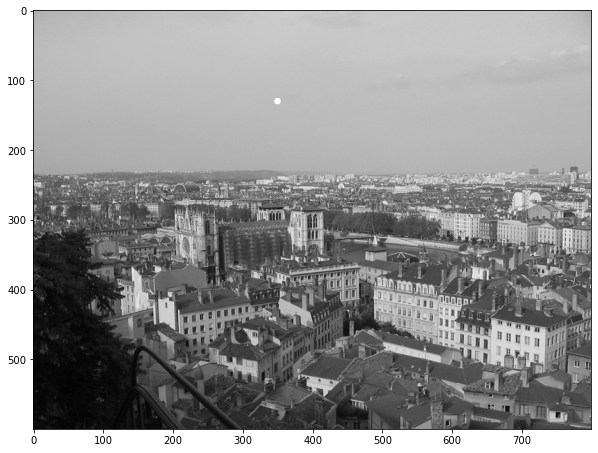

In [9]:
def display_img_segm(img, seg):
    img_out = img.copy()
    for x in range(img_out.shape[0]):
        for y in range(img_out.shape[1]):
            img_out[x, y] = img_out[x, y] if seg[x, y]==0 else 1
    display_image(img_out)
    
display_img_segm(img_gray, initialize_segmentation((130,350),img_gray.shape))

In [10]:
def len_2D(array):
    count = 0 
    for line in array:
        count += line.sum()
    return count
        

def segmentation_region_growing(img,seed_pt,tau):
    seg_init = initialize_segmentation(seed_pt,img.shape)
    patch_neighbourhood = np.array([[0,1,0], [1,1,1], [0,1,0]])
    varation_len_seg_init = (0, len_2D(seg_init))

    while varation_len_seg_init[0] != varation_len_seg_init[1]:

        region = np.array([elt for elt in np.multiply(img, seg_init).reshape(-1) if elt != 0])
        mu = region.mean()
        pixels_in_neighbourhood = morph.dilation(seg_init, patch_neighbourhood) - seg_init
        
        for x in range(pixels_in_neighbourhood.shape[0]):
            for y in range(pixels_in_neighbourhood.shape[1]):
                if pixels_in_neighbourhood[x, y] == 1:
                    if abs(img[x, y] - mu) < tau:
                        seg_init[x, y] = 1

                        
        varation_len_seg_init = (varation_len_seg_init[1], len_2D(seg_init))
    
    seg_n = np.empty_like(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            seg_n[x, y] = 1 if seg_init[x, y] == 1 else img[x, y]
                
    return seg_n,seg_init

Carry out the segmentation on the input image with the seed point and threshold specified in the following code :

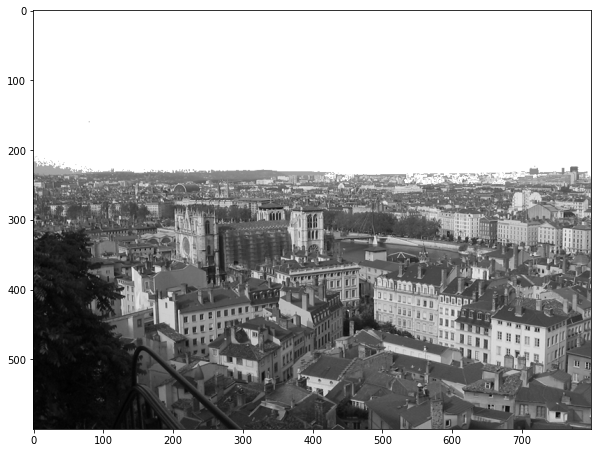

In [11]:
seed_pt = (130,350)
tau = 20.0 * (1.0/256.0)
img_out_region_growing,seg_init = segmentation_region_growing(img_gray,seed_pt,tau)
display_image(img_out_region_growing)
write_image(seg_init,file_name+'_segmentation_region_growing_init.png')
write_image(img_out_region_growing,file_name+'_segmentation_region_growing.png')

__Question 1.3__ What final problem, especially concering the boundary between the regions, can you see ? What method could be used instead of region growing, could solve this problem ?

__Answer__ Le problème que l'on obsevre est situé pour les objets de l'image différents mais qui ont des teintes très similaires. L'algorithme a du mal a distinguer la différence entre le ciel et la coline ainsi que le ciel et quelques immeubles car les intensités sont très similaires. Un méthode que nous pourrions utiliser pour améliorer les résultats est celle d''Active contours'.

Un autre problème est que le temps de calcul de cet algorithme est élevé, ce qui pourrait être ennuyeux pour une utilisation par photoshop par exemple.